In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import warnings
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.autograd import Variable
import torchvision.transforms as transforms
from PIL import Image, ImageFile
from torch.utils.data import TensorDataset, DataLoader,Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import copy 

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Any results you write to the current directory are saved as output.
use_cuda = torch.cuda.is_available()
sns.set(style="darkgrid")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if not use_cuda:
    print('No GPU found. Please use a GPU to train your neural network.')

In [14]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('sample_submission.csv')

In [31]:
#df_train = df_train[:18528]
print(df_train.shape)
print(df_test.shape)
df_train.head()

(18540, 2)
(2009, 2)


,image_id,category
0,0,77
1,1,81
2,2,52
3,3,72
4,4,58


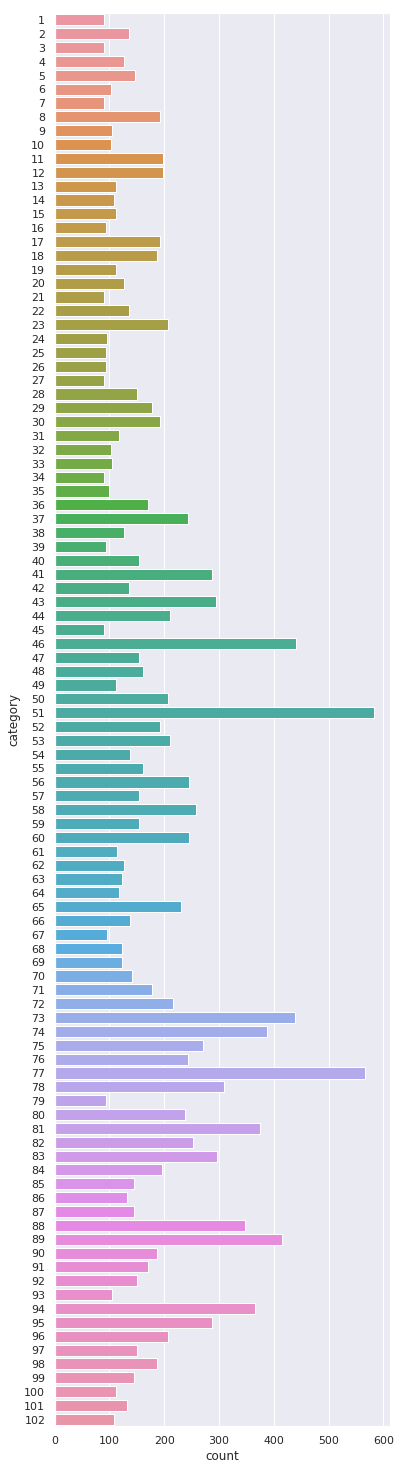

In [16]:
plt.figure(figsize=(6, 26))
sns.countplot(y="category", data=df_train)

In [17]:
# NOTE: class is inherited from Dataset
class ImageLabelDataset(Dataset):
    def __init__(self, df_data, prediction, folder="train", transformtype="train"):
        super().__init__()
        self.df = df_data
        self.prediction = prediction
        self.folder = folder
        self.transformtype = transformtype

    def __len__(self):
        return len(self.df)
    
    @property
    def train_labels(self):
        warnings.warn("train_labels has been renamed targets")
        return self.prediction
    
    def __getitem__(self, index):
        tensorimage = self.preprocess_image(self.df[index], self.transformtype)
        label = self.prediction[index]
        #label_tensor = self.get_dummies(label)
        label_tensor = int(label)
        #x = np.squeeze(label_tensor.detach().cpu().numpy())
        #print(x.argsort()[-6:][::-1])
        #print(len(label_tensor))
        #print(label_tensor.shape)
        return tensorimage, label_tensor    
   
    def preprocess_image(self, img_path, transformtype):
        data_transform = transforms.Compose([transforms.ToPILImage(),
                                             #transforms.Resize(256),
                                             transforms.RandomResizedCrop(224),
                                             transforms.RandomHorizontalFlip(),
                                             transforms.RandomVerticalFlip(),
                                             transforms.RandomRotation(degrees=40), 
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                            ])
        
        test_transform = transforms.Compose([transforms.ToPILImage(),
                                             transforms.Resize(256),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                            ])
        
        image = cv2.imread("{}/{}.jpg".format(self.folder, img_path))
        if(transformtype == "train"):
            image = data_transform(image)
        else:
            image = test_transform(image)
        return image
    
    def get_dummies(self, attribute_id):
        label_tensor = torch.zeros((1, 102))
        #label_tensor = torch.zeros((1, 1))
        #for label in attribute_id.split():
        label_tensor[0, int(attribute_id)-1] = 1
        #label_tensor[0, 0] = attribute_id
        return label_tensor

In [18]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    """

    def __init__(self, dataset, indices=None, num_samples=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices
            
        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        dataset_type = type(dataset)
        if dataset_type is torchvision.datasets.MNIST:
            return dataset.train_labels[idx].item()
        elif dataset_type is ImageLabelDataset:
            return dataset.train_labels[idx].item()
        else:
            raise NotImplementedError
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))


In [29]:
# df_train.head()
batch_size = 64
train_image = df_train["image_id"]
#target = df_train.drop(['id', 'attribute_ids'],axis=1)
target = df_train["category"]
X_train, X_val, y_train, y_val = train_test_split(train_image.values, target.values, test_size=0.20)

#smt = SMOTE()
#X_train, y_train = smt.fit_sample(X_train.reshape(-1, 1), y_train)
#print(np.bincount(y_train))

test_image = df_test["image_id"]
test_target = df_test["category"]
#test_target = df_test.drop(['id', 'attribute_ids'],axis=1)

train_set = ImageLabelDataset(df_data=X_train, prediction=y_train, folder="train", transformtype="train")
val_set = ImageLabelDataset(df_data=X_val, prediction=y_val, folder="train", transformtype="test")
predict_set = ImageLabelDataset(df_data=test_image, prediction=test_target, folder="test", transformtype="test")

train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=batch_size, 
                                           sampler=ImbalancedDatasetSampler(train_set),
                                           num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(predict_set, batch_size=1, shuffle=False, num_workers=0)


/home/koushik/.conda/envs/deep-learning/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: train_labels has been renamed targets
  from ipykernel import kernelapp as app
/home/koushik/.conda/envs/deep-learning/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: train_labels has been renamed targets
  from ipykernel import kernelapp as app
/home/koushik/.conda/envs/deep-learning/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: train_labels has been renamed targets
  from ipykernel import kernelapp as app
/home/koushik/.conda/envs/deep-learning/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: train_labels has been renamed targets
  from ipykernel import kernelapp as app
/home/koushik/.conda/envs/deep-learning/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: train_labels has been renamed targets
  from ipykernel import kernelapp as app
/home/koushik/.conda/envs/deep-learning/lib/python3.7/site-packages/ip

/home/koushik/.conda/envs/deep-learning/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: train_labels has been renamed targets
  from ipykernel import kernelapp as app
/home/koushik/.conda/envs/deep-learning/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: train_labels has been renamed targets
  from ipykernel import kernelapp as app
/home/koushik/.conda/envs/deep-learning/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: train_labels has been renamed targets
  from ipykernel import kernelapp as app
/home/koushik/.conda/envs/deep-learning/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: train_labels has been renamed targets
  from ipykernel import kernelapp as app
/home/koushik/.conda/envs/deep-learning/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: train_labels has been renamed targets
  from ipykernel import kernelapp as app
/home/koushik/.conda/envs/deep-learning/lib/python3.7/site-packages/ip

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [21]:
# Hyperparameters
n_output=1
# Number of Epochs
num_epochs = 20
# Learning Rate
learning_rate = 0.0001
# Model parameters

# Show stats for every n number of batches
show_every_n_batches = 1

In [22]:
model_transfer = models.densenet121(pretrained=True)
print(model_transfer)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [23]:
def train_rnn(model, batch_size, optimizer, criterion, n_epochs, show_every_n_batches=100):
    train_loss = 0
    valid_loss = 0
    valid_corrects = 0
    batch_losses = []
    val_batch_losses = []
    valid_loss_min = np.Inf
    
    model.train()
    
    previousLoss = np.Inf
    minLoss = np.Inf

    print("Training for %d epoch(s)..." % n_epochs)
    for epoch_i in range(1, n_epochs + 1):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            #print(batch_idx + len(train_loader.dataset))
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            target = np.squeeze(target)
            #target = target.view(1,-1)
            target = target.long()
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward pass: Train compute predicted outputs by passing inputs to the model            
            output = model(data)
            #print(output.squeeze())
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item() * data.size(0)
            
        model.eval()
        for batch_idx, (data, target) in enumerate(val_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            target = np.squeeze(target)
            target= target.long()
            # zero the parameter gradients
            optimizer.zero_grad()
            output = model(data)
            _, preds = torch.max(output, 1)
            #print(output)
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item() * data.size(0)
            #print(loss.item())
            valid_corrects += torch.sum(preds == target.data)
        
        valid_loss = valid_loss/len(val_loader.dataset)
        train_loss = train_loss/len(train_loader.dataset)
        valid_corrects = valid_corrects.double()/len(val_loader.dataset)
        
        # print training/validation statistics 
        if epoch_i%show_every_n_batches == 0:
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch_i, train_loss, valid_loss))
        
            ## TODO: save the model if validation loss has decreased
            # save model if validation loss has decreased
            if valid_loss < valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Accuracy ({:.3}) Saving model ...'.format(
                valid_loss_min,
                valid_loss, valid_corrects))
                with open('trained_rnn_new', 'wb') as pickle_file:
                    torch.save(model.state_dict(), 'save/trained_rnn_new')
                valid_loss_min = valid_loss
                train_loss = 0
                valid_loss = 0
                valid_corrects = 0
                #batch_losses = []
                #val_batch_losses = []
  
    return model

In [24]:
# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    #print(param.requires_grad)
    param.requires_grad = False

## Freezing all layers
#for params in model_transfer.parameters():
#    params.requires_grad = False

custom_model = nn.Linear(1024, 102)

"""
custom_model = nn.Sequential(nn.Linear(1024, 256), 
                  nn.ReLU(),
                  nn.Dropout(p=0.25), 
                  nn.Linear(256, 102)
                 )
"""
if use_cuda:
    custom_model = custom_model.to(device)
    
model_transfer.fc = custom_model
#model_transfer.classifier = custom_model
#decay_rate = learning_rate / num_epochs

#model_transfer.load_state_dict(torch.load('save/trained_rnn_new'))

if use_cuda:
    model_transfer = model_transfer.cuda()

# print(model_transfer)

# specify loss function
criterion_scratch = nn.CrossEntropyLoss()
#criterion_scratch = nn.BCELoss()
#criterion_scratch = nn.BCELoss(reduction="mean").to('cuda:0')

# specify optimizer

optimizer_scratch = optim.Adadelta(model_transfer.parameters())
#optimizer_scratch = optim.SGD(model_transfer.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.000001)
#optimizer_scratch = optim.Adam(model_transfer.classifier.parameters(), lr=learning_rate)
#optimizer_scratch = optim.SGD(list(filter(lambda p: p.requires_grad, model_transfer.parameters())), lr=learning_rate, momentum=0.9)


trained_rnn = train_rnn(model_transfer, batch_size, optimizer_scratch, criterion_scratch, num_epochs, show_every_n_batches)

Training for 20 epoch(s)...
Epoch: 1 	Training Loss: 3.762307 	Validation Loss: 2.408907
Validation loss decreased (inf --> 2.408907).  Accuracy (0.396) Saving model ...
Epoch: 2 	Training Loss: 1.618611 	Validation Loss: 1.557055
Validation loss decreased (2.408907 --> 1.557055).  Accuracy (0.597) Saving model ...
Epoch: 3 	Training Loss: 1.197843 	Validation Loss: 1.165015
Validation loss decreased (1.557055 --> 1.165015).  Accuracy (0.698) Saving model ...
Epoch: 4 	Training Loss: 1.022265 	Validation Loss: 0.873503
Validation loss decreased (1.165015 --> 0.873503).  Accuracy (0.778) Saving model ...
Epoch: 5 	Training Loss: 0.926149 	Validation Loss: 0.871565
Validation loss decreased (0.873503 --> 0.871565).  Accuracy (0.779) Saving model ...
Epoch: 6 	Training Loss: 0.855830 	Validation Loss: 0.726615
Validation loss decreased (0.871565 --> 0.726615).  Accuracy (0.811) Saving model ...
Epoch: 7 	Training Loss: 0.802758 	Validation Loss: 0.641260
Validation loss decreased (0.72661

In [26]:
model_transfer.load_state_dict(torch.load('save/trained_rnn_new'))
model_transfer.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [27]:
accuracy = 0
model_transfer.eval()
count = 0
for batch_idx, (inputs, labels) in enumerate(val_loader):
    if use_cuda:
        inputs, labels = inputs.cuda(), labels.cuda()
        
    outputs = model_transfer(inputs)
    # Class with the highest probability is our predicted class
    equality = r2_score(labels.data.cpu(), outputs.cpu().max(1)[1])
    #print(equality)
    count += 1
    # Accuracy is number of correct predictions divided by all predictions
    accuracy += equality

#print(accuracy)
#print(count)
#print(accuracy/count)
#print(len(val_loader.dataset))
print("Test accuracy: {:.3f}".format(accuracy/len(val_loader)))

Test accuracy: 0.638


In [32]:
test_preds = []
submission = df_test
for batch_idx, (data, target) in enumerate(test_loader):
    # move to GPU
    if use_cuda:
        data = data.cuda()
        
    output = model_transfer(data)
    output = outputs.detach().cpu().max(1)[1]
    output = output.numpy().squeeze()
    #print(output)
    test_preds = np.concatenate((test_preds, output), axis=0).astype(int)

print(test_preds)    
print(len(test_preds))
print(submission.shape)
submission["category"] = test_preds
display(submission.head())


[58 50 22 ... 49 48 17]
78351
(2009, 2)


ValueError: Length of values does not match length of index

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
%reset